In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

path = "/content/drive/MyDrive/dataset/raw data.csv"
data = pd.read_csv(path)

data = pd.get_dummies(data) #convert categorical variable into dummy variable

y = np.array(data['CR (%)']) #output feature
X = data.drop(['CR (%)', 'ECR PY (%)', 'PDOs PY (%)', 'POHs PY (%)', 'V'], axis=1) #input feature - axis=1 refers to the column

X_list = list(X.columns) # Saving feature names for later use

from sklearn.preprocessing import StandardScaler #standardscaler for normalization (Jinesh et al., 2023)
scaler = StandardScaler()

y = y.reshape(-1, 1) #normalizing y
scaler.fit(y)
y = scaler.transform(y)

scaler.fit(X) #normalizing X
X = scaler.transform(X)

X = np.array(X) # Convert to numpy array

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)
print('Training X Shape:', train_X.shape)
print('Training y Shape:', train_y.shape)
print('Testing X Shape:', test_X.shape)
print('Testing y Shape:', test_y.shape)

#imputation for missing value using kNN algo
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10) #create an instance of KNNImputer class, k is desired number of neighbours

#perform imputation on on X because y no missing values
imp_train_X = imputer.fit_transform(train_X)
imp_test_X = imputer.fit_transform(test_X)

#hyperparamter optimization using gridsearch
random_cv = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={'learning_rate': [0.05, 0.1, 0.3, 0.5, 1.0], #0.3 0.05, 0.1, 0.15, 0.2, 0.25
                        'max_depth': [0, 4, 6, 8, 10], #6
                        'min_child_weight': [0, 1, 2, 3, 5], #1
                        #'gamma':[0, 0.5, 1],
                        #'colsample_bytree':[0.4, 0.5, 0.6], #0.5
                        #'subsample': [0, 1], #1
                        #'max_leaves': [1, 2, 3],
                        #'random_state': [0],
                        'n_estimators': [100, 1000, 3000, 5000, 7000],
                        #'alpha': [0, 1.0, 2.0],
                        #'lambda': [0, 1.0, 2.0]
                        }, #5000
            cv=3, scoring='r2', verbose=0, n_jobs=-1)
#This includes 3-fold validation (cv=3) and uses mean scare error as the metric for evaluation
#if you prefer a quieter training process without any output messages, you can set verbose to 0

random_cv.fit(imp_train_X,train_y)

# use the best parameters
best_params = random_cv.best_params_
best_score = random_cv.best_score_
print('\n Best hyperparameters:', best_params)
print('\n Best score:', best_score)

# # using the best parameters run XGBoost
model = XGBRegressor(**best_params)
model.fit(imp_train_X, train_y)

# #check the validation
score = model.score(imp_train_X,train_y)
print("Training score: ", score)

predictions = model.predict(imp_test_X)

# print("Mean Absolute Error: " + str(mean_absolute_error(test_y, predictions)))
# print("MSE: " + str(mean_squared_error(predictions, test_y)))

# RMSE = sqrt(mean_squared_error(predictions, test_y))

# print("RMSE: " + str(RMSE))
print("R2 score: " + str(r2_score(test_y, predictions)))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 6.7 MB/s eta 0:00:00
Training X Shape: (312, 30)
Training y Shape: (312,)
Testing X Shape: (134, 30)
Testing y Shape: (134,)
Training score:  0.999483810192362
Mean Absolute Error: 3.735515628999739
MSE: 24.290625349648053
RMSE: 4.9285520540670005
R2 score: 0.976557227671207
[0.98010313 0.95171769 0.98875901 0.96465359 0.97402539 0.96711016
 0.94822063 0.97425612 0.97311832 0.98040096]


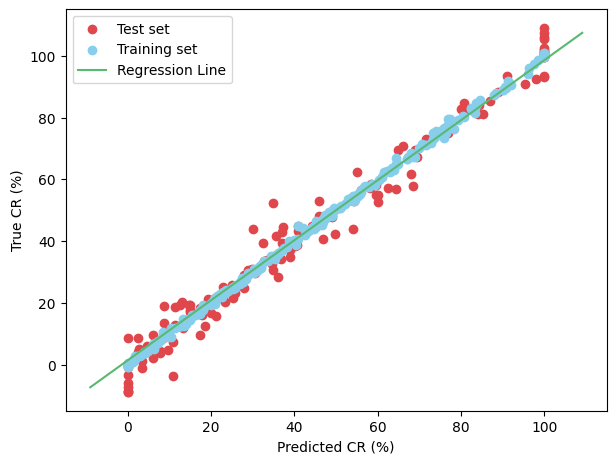

In [ ]:
###############finale!
!pip install shap
!pip install joypy
from math import sqrt
import pandas as pd
import numpy as np
import os
import shap
import joypy
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

path = "/content/drive/MyDrive/dataset/raw data.csv"
data = pd.read_csv(path)

data = pd.get_dummies(data) #convert categorical variable into dummy variable

yo = np.array(data['CR (%)']) #output feature
Xi = data.drop(['CR (%)', 'ECR PY (%)', 'PDOs PY (%)', 'POHs PY (%)', 'V'], axis=1) #input feature - axis=1 refers to the column

Xi_list = list(Xi.columns) # Saving feature names for later use

# from sklearn.preprocessing import StandardScaler #standardscaler for normalization (Jinesh et al., 2023)
# scaler = StandardScaler()

# yo = yo.reshape(-1, 1) #normalizing y
# scaler.fit(yo)
# yo = scaler.transform(yo)

# scaler.fit(Xi) #normalizing X
# Xi = scaler.transform(Xi)

Xi = np.array(Xi) # Convert to numpy array

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(Xi, yo, test_size = 0.3, random_state = 42)
print('Training X Shape:', train_X.shape)
print('Training y Shape:', train_y.shape)
print('Testing X Shape:', test_X.shape)
print('Testing y Shape:', test_y.shape)

#imputation for missing value using kNN algo
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10) #create an instance of KNNImputer class, k is desired number of neighbours

#perform imputation on on X because y no missing values
imp_train_X = imputer.fit_transform(train_X)
imp_test_X = imputer.fit_transform(test_X)

#xgboost regression
model = XGBRegressor(learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=3000, reg_alpha=0, gamma=0, reg_lambda=0) #already in default - reg_alpha=0, gamma=0, reg_lambda=0, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=1000
model.fit(imp_train_X, train_y,
          eval_set=[(imp_test_X, test_y)],
          verbose=False)

score = model.score(imp_train_X,train_y)
print("Training score: ", score)

predictions = model.predict(imp_test_X) #predicted, expected = test_y

print("Mean Absolute Error: " + str(mean_absolute_error(test_y, predictions)))
print("MSE: " + str(mean_squared_error(predictions, test_y)))

RMSE = sqrt(mean_squared_error(predictions, test_y))
r2score = r2_score(test_y, predictions)

print("RMSE: " + str(RMSE))
print("R2 score: " + str(r2score))

#draw draw draw!
import matplotlib.pyplot as plt

plt.xlim(-10,100)
plt.ylim(-10,100)

# Plot the predicted values
plt.scatter(test_y, predictions, color='#e0474c', label='Test set') #real values call

train_predictions = model.predict(imp_train_X)
plt.scatter(train_y, train_predictions, color='#87ceeb', label='Training set') #real values call

plt.xlabel("Predicted CR (%)")
plt.ylabel("True CR (%)")
plt.tight_layout()

# Perform K-Fold CV
scores = cross_val_score(model, imp_train_X, train_y, cv=10, scoring='r2')
print (scores)

#regression line
X = predictions
Y = test_y

# Mean X and Y
mean_x = np.mean(X)
mean_y = np.mean(Y)

# Total number of values
n = len(X)

# Using the formula to calculate 'm' and 'c'
numer = 0
denom = 0
for i in range(n):
 numer += (X[i] - mean_x) * (Y[i] - mean_y)
 denom += (X[i] - mean_x) ** 2
 m = numer / denom #least square method
 c = mean_y - (m * mean_x)

# Plotting Values and Regression Line
max_x = np.max(X) + 0 #extrapolating
min_x = np.min(X) - 0

# Calculating line values x and y
x = np.linspace(min_x, max_x, 1000)
y = c + m * x
ax = plt.plot(x, y, color='#58b970', label='Regression Line')

#plt.plot([0, 80], [0, 80], color='black', label='Regression line')
#plt.plot(x_sorted, y_pred_sorted,  color='black', label='Regression line')
plt.axis('tight')
plt.legend()


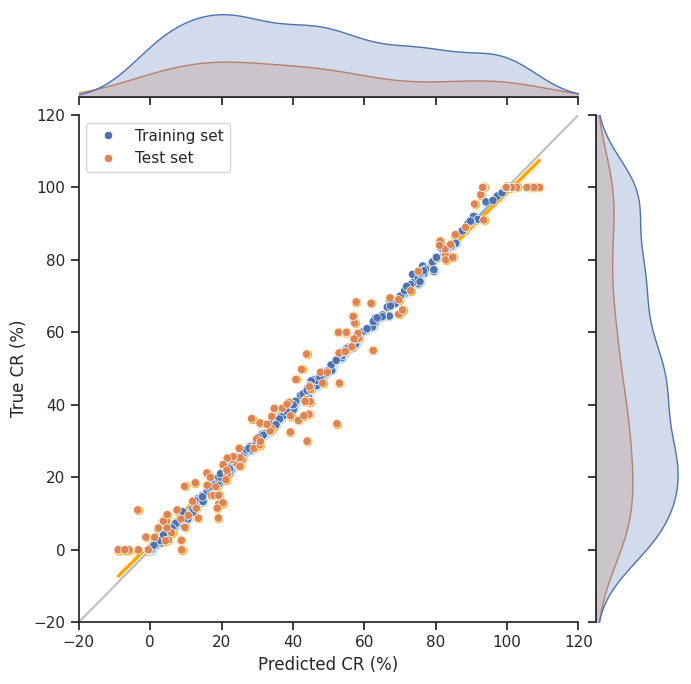

In [ ]:
from seaborn._core.properties import FontSize
import seaborn as sns

#draw draw draw!
import matplotlib.pyplot as plt

#jointplot sns
data_train = pd.DataFrame({'Predicted CR (%)': train_predictions, 'True CR (%)': train_y, '': 'Training set'})
data_test = pd.DataFrame({'Predicted CR (%)': predictions, 'True CR (%)': test_y, '': 'Test set'})

data_combined = pd.concat([data_train, data_test])
sns.set(style="ticks")
g = sns.jointplot(data=data_combined, x='Predicted CR (%)', y='True CR (%)', hue='', kind='scatter', height=7, zorder=5)
sns.regplot(data=data_train, x='Predicted CR (%)', y='True CR (%)', ax=g.ax_joint, color='lightblue') #zorder=1,  scatter=False,
sns.regplot(data=data_test, x='Predicted CR (%)', y='True CR (%)', ax=g.ax_joint, color='orange') #zorder=1,  scatter=False,

g.ax_joint.set_xlim(-20, 120)
g.ax_joint.set_ylim(-20, 120)

# Draw a line of x=y
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, 'gray', alpha=0.5)


Text(102.54687499999999, 0.5, 'Features')

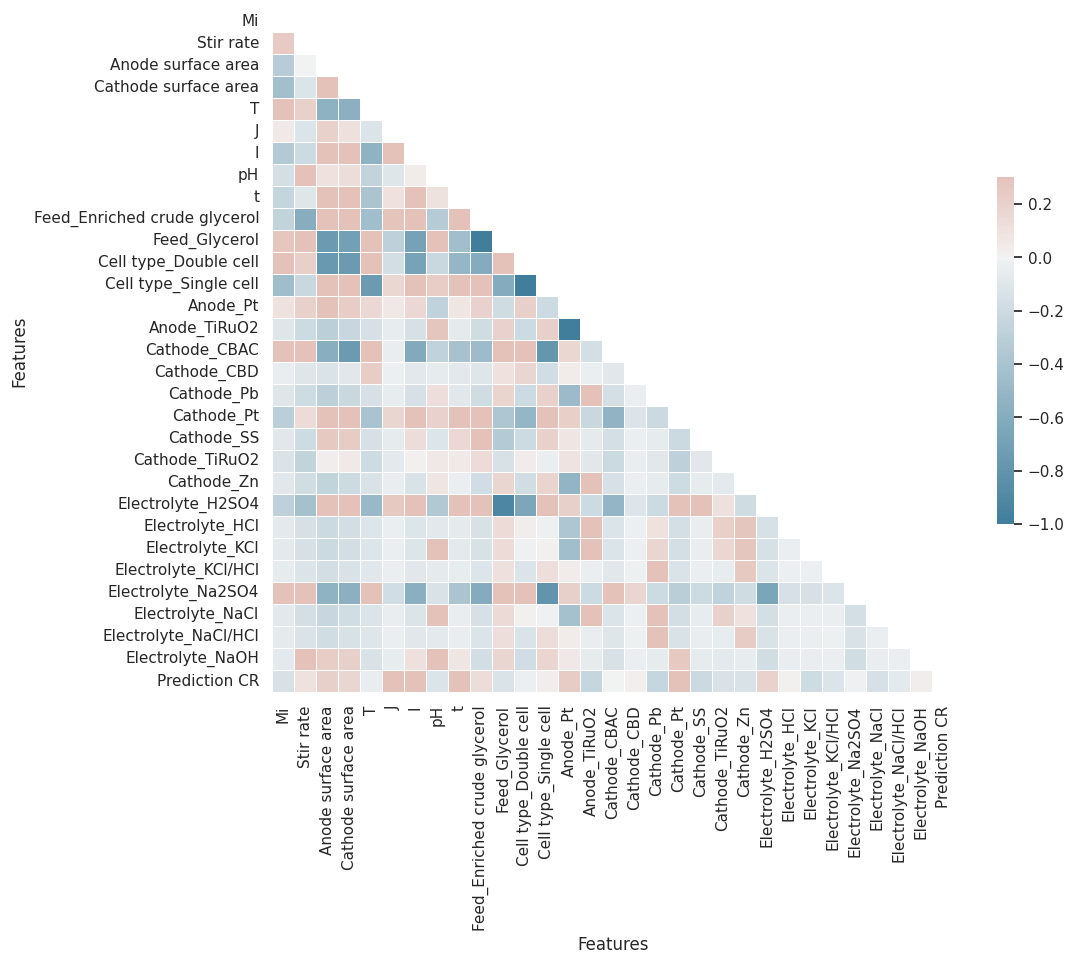

In [ ]:
# Create a DataFrame from the predicted labels and the features
d = pd.DataFrame(imp_train_X, columns=[Xi_list])
d['Prediction CR'] = train_predictions

# Compute the correlation matrix
corr_matrix = d.corr()

# Plot the diagonal correlation matrix
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set x-axis label
plt.xlabel("Features")

# Set y-axis label
plt.ylabel("Features")

PermutationExplainer explainer: 135it [01:27,  1.40it/s]


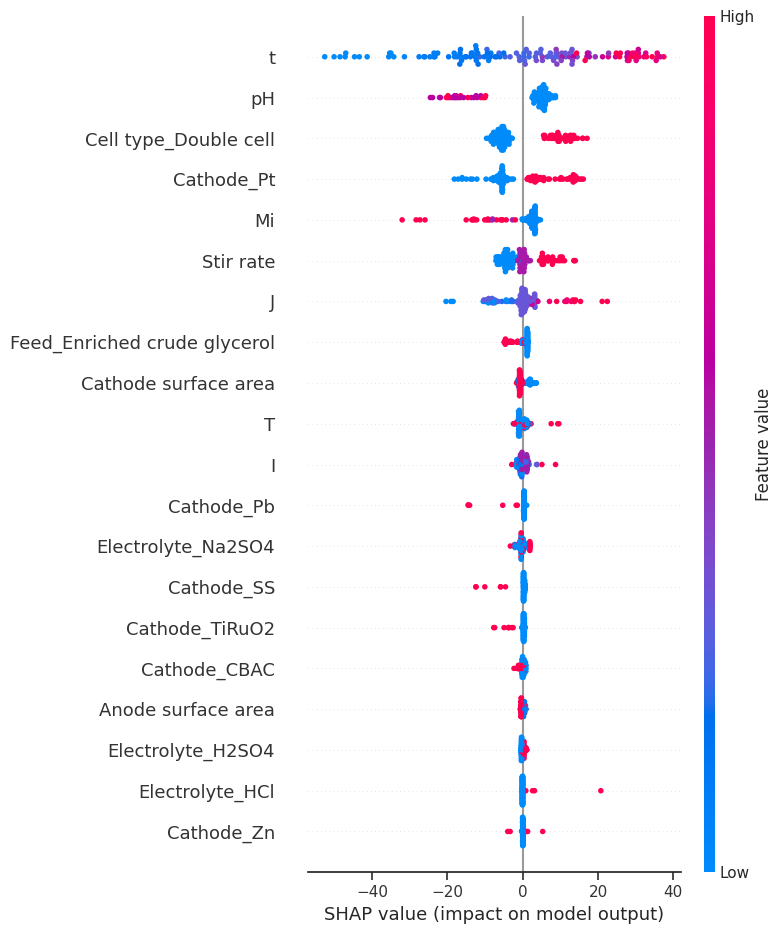

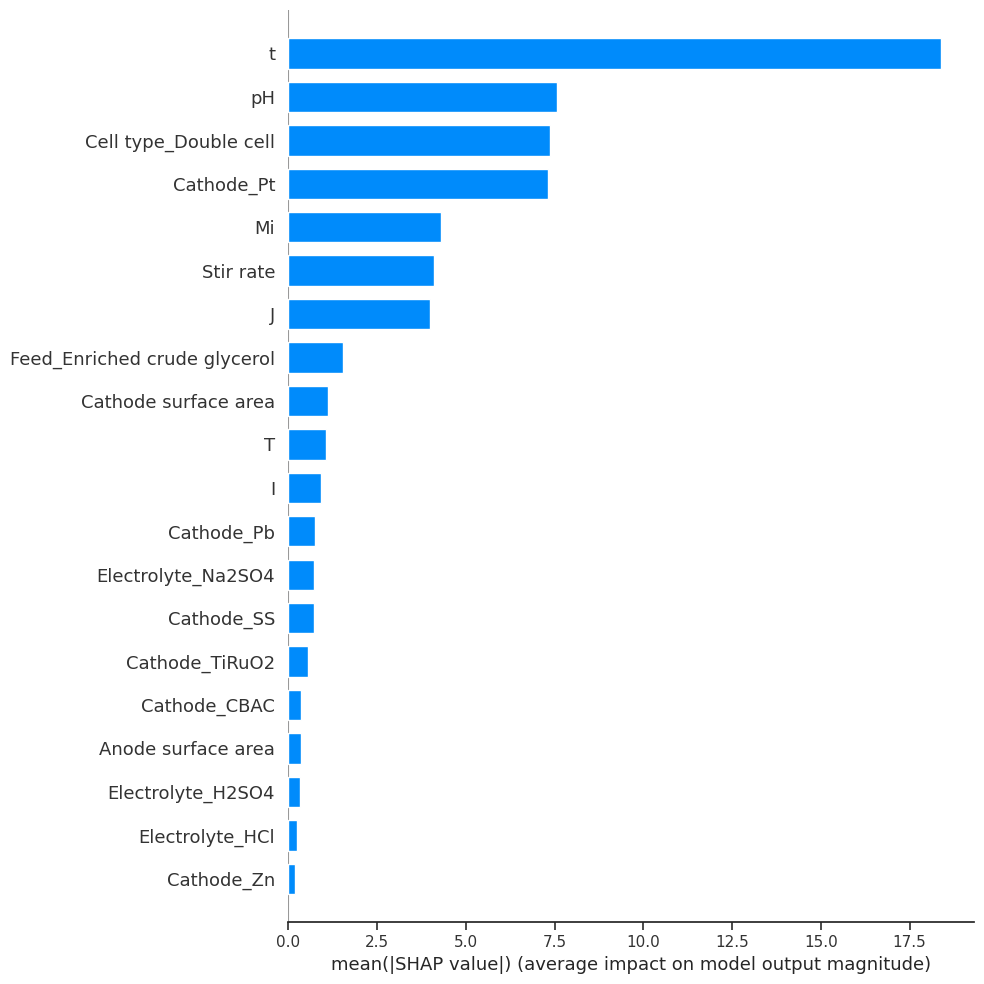

In [ ]:
feature_names = Xi_list

explainer = shap.Explainer(model.predict, imp_test_X)
shap_values = explainer(imp_test_X)
shap.summary_plot(shap_values, feature_names=feature_names)

#bar plot
shap.summary_plot(shap_values, feature_names=feature_names, plot_type="bar", plot_size=(10, 10), show=False)


In [ ]:
pip install --upgrade scikit-learn

In [ ]:
#Permutation importance with sklearn library
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(model, imp_train_X, train_y, n_repeats=30, random_state=42)

# Get the feature importances
feature_importance = perm_importance.importances_mean

# Get the indices of the features ranked by importance
feature_indices = np.argsort(feature_importance)[::-1]

# Print feature importances
for i in feature_indices:
    print(f"Feature {i}: {Xi_list[i]} - Permutation Importance: {feature_importance[i]}")

Feature 8: t - Permutation Importance: 1.3233335885996418
Feature 18: Cathode_Pt - Permutation Importance: 0.3233949937168179
Feature 11: Cell type_Double cell - Permutation Importance: 0.20665356231575846
Feature 7: pH - Permutation Importance: 0.1955821767083309
Feature 5: J - Permutation Importance: 0.15895936861024898
Feature 0: Mi - Permutation Importance: 0.08355015047969966
Feature 1: Stir rate - Permutation Importance: 0.05792525826524783
Feature 19: Cathode_SS - Permutation Importance: 0.02174424650198696
Feature 4: T - Permutation Importance: 0.018643136538727626
Feature 9: Feed_Enriched crude glycerol - Permutation Importance: 0.015370190122135878
Feature 23: Electrolyte_HCl - Permutation Importance: 0.014778453331191174
Feature 20: Cathode_TiRuO2 - Permutation Importance: 0.014181184920448554
Feature 6: I - Permutation Importance: 0.011817354803008077
Feature 17: Cathode_Pb - Permutation Importance: 0.009758786249557267
Feature 26: Electrolyte_Na2SO4 - Permutation Importanc

Training X Shape: (356, 31)
Training y Shape: (356,)
Testing X Shape: (90, 31)
Testing y Shape: (90,)
[[2.5000e-01 0.0000e+00 1.1000e+01 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [3.0000e-01 3.5000e+02 2.2000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.0000e-01 0.0000e+00 1.2138e+02 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [3.0000e-01 6.5000e+02 1.2138e+02 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [3.0000e+00 3.5000e+02 2.2000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [3.0000e-01 6.5000e+02 1.2138e+02 ... 0.0000e+00 0.0000e+00 0.0000e+00]]
[ 0.25        0.         11.         11.         25.          0.144
  2.5         2.41666667  7.          4.          0.          1.
  0.          1.          0.          1.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          1.          0.
  0.        ]
[11.    11.     0.144  2.5    4.     0.     1.     0.     1.     0.
  1.     0.     0.     0.     0.     0.     

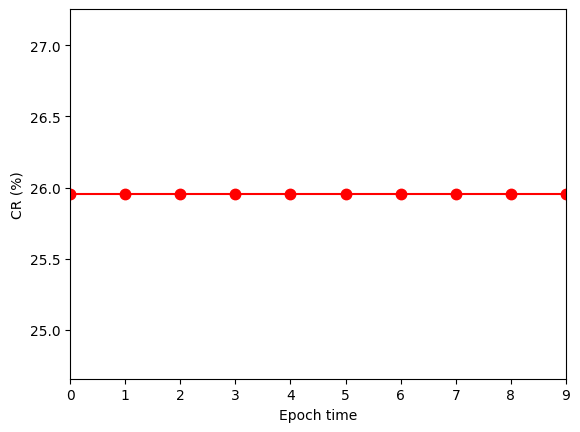

In [ ]:
#PSO
# bismillah, ye sun et al. - 6 - edit again and again. I think this is the fourth time, but issokay
# alhamdulillah, jadiiiiiiii


#pso experimentation started - we need 10 data combinations with its results and try 3 of them! Bismillah!
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

#imputation for missing value using kNN algo
from sklearn.impute import KNNImputer

path = "/content/drive/MyDrive/dataset/CR.csv"
data = pd.read_csv(path)

data = pd.get_dummies(data) #convert categorical variable into dummy variable

yo = data['CR (%)'] #output feature
xo = data.drop(['CR (%)'], axis=1) #input feature - axis=1 refers to the column

xo_list = list(xo.columns) # Saving feature names for later use
#x = np.array(x) # Convert to numpy array

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

imputer = KNNImputer(n_neighbors=10) #create an instance of KNNImputer class, k is desired number of neighbours

# Split the data into training and testing sets
x1_train, x1_test, y1_train, y1_test = train_test_split(xo, yo, test_size = 0.2, random_state = 42)
print('Training X Shape:', x1_train.shape)
print('Training y Shape:', y1_train.shape)
print('Testing X Shape:', x1_test.shape)
print('Testing y Shape:', y1_test.shape)

#perform imputation on on X because y no missing values
imp_x_train = imputer.fit_transform(x1_train)
imp_x_test = imputer.fit_transform(x1_test)

#xgboost regression
modelpso = XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, verbosity=0) #was optimized using gridsearch
modelpso.fit(imp_x_train, y1_train)
predictions = modelpso.predict(imp_x_test) #predicted, expected = test_y

def set_all_feature_data():
  x_train = imp_x_train
  columns = xo.columns
  y_train = y1_train
  x_test = imp_x_test
  y_test = y1_test
  return x_train, x_test, y_train, y_test, columns

result_x = []
result_y = []

class PSO:
  def __init__(self, dimension, time, size, low, up, v_low, v_high, x_test, x_train):
    self.dimension = dimension
    self.time = time
    self.size = size
    self.bound = []
    self.bound.append(low)
    self.bound.append(up)
    self.v_low = v_low
    self.v_high = v_high
    self.x = np.zeros((self.size, self.dimension))
    self.v = np.zeros((self.size, self.dimension))
    self.p_best = np.zeros((self.size, self.dimension))
    self.g_best = np.zeros((1, self.dimension))[0]
    self.x_test = x_test
    self.x_train = x_train
    temp = 0
    for i in range(self.size):
      for j in range(self.dimension):
        self.x[i][j] = random.uniform(self.bound[0][j], self.bound[1][j])
        self.v[i][j] = random.uniform(self.v_low, self.v_high)
      self.p_best[i] = self.x[i]
      x_test1 = np.insert(self.x_test, 1, self.p_best[i])

      fit = self.fitness(x_test1)
      if fit > temp: #if fit[0] > temp:
        self.g_best = self.p_best[i]
        temp = fit

  def fitness(self, x):
    x = [x]
    x = pd.DataFrame(x)

    y = modelpso.predict(x)
    result_x.append(x[0].tolist())

    result_y.append(y[0])
    return y

  def update(self, size):
    c1 = 2.0
    c2 = 2.0
    w = 0.8
    for i in range(size):
      self.v[i] = w * self.v[i] + c1 * random.uniform(0, 1) * (self.p_best[i] - self.x[i]) + c2 * random.uniform(0, 1) * (self.g_best - self.x[i])
      for j in range(self.dimension):
        if self.v[i][j] < self.v_low:
          self.v[i][j] = self.v_low
        if self.v[i][j] > self.v_high:
          self.v[i][j] = self.v_high

      self.x[i] = self.x[i] + self.v[i]
      for j in range(self.dimension):
        if self.x[i][j] < self.bound[0][j]:
          self.x[i][j] = self.bound[0][j]
        if self.x[i][j] > self.bound[1][j]:
          self.x[i][j] = self.bound[1][j]
      x_test1 = np.insert(self.x_test, 1, self.x[i])
      x_test2 = np.insert(self.x_test, 1, self.p_best[i])
      x_test3 = np.insert(self.x_test, 1, self.g_best)
      if self.fitness(x_test1) > self.fitness(x_test2):
        self.p_best[i] = self.x[i]
      if self.fitness(x_test1) > self.fitness(x_test3):
        self.g_best = self.x[i]

  def pso(self):

    best = []
    self.final_best = np.array([0, 0, 0, 0, 0])
    for gen in range(self.time):
      self.update(self.size)
      x_test1 = np.insert(self.x_test, 1, self.g_best)
      x_test2 = np.insert(self.x_test, 1, self.final_best)
      if self.fitness(x_test1) > self.fitness(x_test2):
        self.final_best = self.g_best.copy()
      print('best location：{}'.format(self.final_best))
      x_test3 = np.insert(self.x_test, 1, self.final_best)
      temp = self.fitness(x_test3)
      print('best position：{}'.format(temp))
      best.append(temp)
    t = [i for i in range(self.time)]
    plt.figure()
    plt.plot(t, best, color='red', marker='.', ms=15)
    plt.margins(0)
    plt.xlabel("Epoch time")
    plt.ylabel("CR (%)")
    plt.title("")
    plt.show()

if __name__ == '__main__':
  predictions = pd.DataFrame(predictions)
  data = predictions
  data = data.values
  filter_index = []
  for i in range(len(data)):
    if data[i][0] > 0:
      filter_index.append(i)
  x_train, y_train, x_test, y_test, columns = set_all_feature_data()
  x_test = pd.DataFrame(imp_x_test)
  #x_test = x_train.iloc[49:50, filter_index]
  #x_test = x_test.iloc[0:1, filter_index]
  x_train = pd.DataFrame(imp_x_train)
  #x_train = x_train.iloc[:, filter_index]
  x_test = x_test.values
  print(x_test)
  x_test = x_test[0]
  print(x_test)

  x_test = np.delete(x_test, [0, 1, 4, 7, 8])
  print(x_test)

  time = 10
  size = 50
  dimension = 5
  v_low = -2
  v_high = 2
  low = [0.25, 0, 25, 1, 0]  # List of minimum boundary values - 0.25, 0, 25, -1.8, 1, 0
  up = [4.35, 650, 80, 11, 24]  # List of maximum boundary - 4.35, 650, 80, 23, 11, 24
  pso = PSO(dimension, time, size, low, up, v_low, v_high, x_test, x_train)
  pso.pso()

  result_x = pd.DataFrame(result_x)
  result_x["new"] = result_y
  #print(result_x)
  #print(result_y)

  #print the result into an excel file
  # writer = pd.ExcelWriter("/content/drive/MyDrive/dataset/result_x.xlsx")
  # pd.DataFrame(result_x).to_excel(writer, sheet_name='sheet1', index=False)
  # writer.save()
